In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations as comb

from tools.data_loading import get_lincs
from tools.metrics import primary_dists, get_consistency

# Data Loading

In [2]:
lincs, lincs_genes, cell_lines = get_lincs()

Pulling folder parsed/literature_datasets/L1000
Pulling folder parsed/proteins


In [3]:
lincs.shape # num KOs X num transcripts X num cell lines

(5002, 978, 9)

## Z-score filter for DEGs

Given that the LINCS data corresponds to the z-scores of ~1000 transcripts relative to WT for our groups of KOs and most KOs don't have a strong effect on most transcripts, it's expected that there will be a high degree of noise in the data.

To get around this we can instead threshold our data, for example by binarising and defining differentially expressed genes DEGs on a per-KO basis

In [4]:
THRESH = 1.96
lincs[abs(lincs)<THRESH] = 0
lincs[abs(lincs)>THRESH] = 1

### Creating a Null
In order to compare the following experiments with something, within each cell line i'll create a random effect null model by shuffling the rows in each cell line (handling cell lines independently).

In [5]:
#firstly will make a null
lincs_shuffled = np.copy(lincs)
for cell_line in np.arange(lincs.shape[-1]):
    order = np.arange(lincs.shape[0])
    np.random.shuffle(order)
    lincs_shuffled[:,:,cell_line] = lincs[order,:,cell_line] 

## Distance Calculations

Since we now have binary vectors we'll need an appropriate distance metric. One such metric is the Jaccard distance defined as:

$1 - \frac{|U\cap V|}{|U\cup V|}$

For sets $U$ and $V$. 

Essentially we're asking what the size of the overlap is relative to the size of the DEG sets.

In [6]:
metric = 'jaccard'
dists= {'real':primary_dists(lincs, metric = metric),
        'shuffled':primary_dists(lincs_shuffled, metric = metric)}

As a sanity check, let's see how well these Jaccard distances correlate across cell line pairs:

In [10]:
r2s = {'real':[], 'shuffled':[]}
idxs = np.triu_indices(dists['real'].shape[-1],1)
for cpair in comb(np.arange(dists['real'].shape[0]),2):
    for key in dists:
        r2s[key].append(np.corrcoef(dists[key][cpair[0],:,:][idxs], dists[key][cpair[1],:,:][idxs])[0,1])

[Text(1, 0, 'Real'), Text(2, 0, 'Shuffled')]

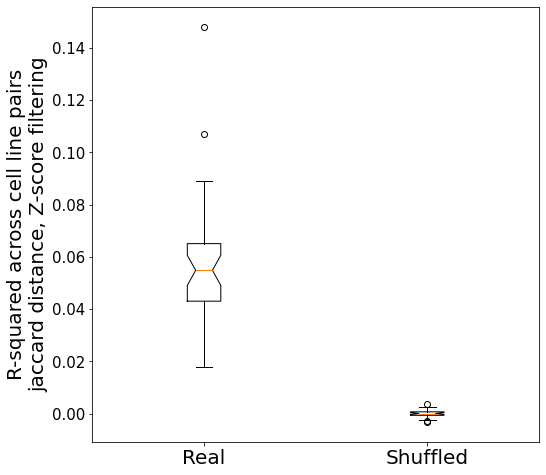

In [11]:
fig, ax = plt.subplots(1, figsize = (8,8))
ax.boxplot([r2s['real'],r2s['shuffled']], notch = True)
ax.set_ylabel(f"R-squared across cell line pairs\n{metric} distance, Z-score filtering",size = 20)
ax.tick_params(labelsize = 15)
ax.set_xticklabels(['Real','Shuffled'], size = 20)

Better than random - but pretty poor correlations overall.

Let's also take a look at the median jaccard distance between KOs across cell lines - what we want to see is a heavy lower tail in the distribution compared to random chance. This would essentially suggest that there are KOs which are consistently 'closer' than we would expect by random chance.

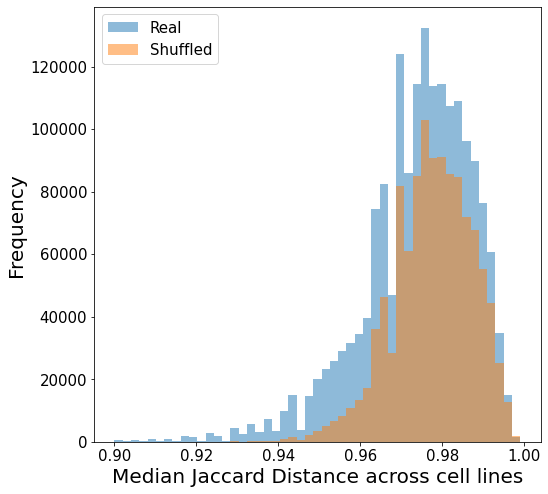

In [17]:
fig, ax = plt.subplots(1, figsize = (8,8))

med_dists = np.median(dists['real'], axis = 0)
indices = np.triu_indices(med_dists.shape[0], 1)
vals = med_dists[indices]
xlim = [0.9,0.999]
ax.hist(vals[vals!=0], bins = np.linspace(xlim[0],xlim[1],50),alpha = 0.5, label = 'Real')

med_dists_shuffled = np.median(dists['shuffled'], axis = 0)
indices = np.triu_indices(med_dists_shuffled.shape[0], 1)
vals = med_dists_shuffled[indices]
ax.hist(vals[vals!=0], bins = np.linspace(xlim[0],xlim[1],50),alpha = 0.5, label = 'Shuffled')

ax.set_xlabel("Median Jaccard Distance across cell lines", size = 20)
ax.set_ylabel("Frequency", size = 20)
ax.tick_params(labelsize = 15)
ax.legend(prop = {'size':15})


We do have a heavy lower tail here but the overall Jaccard distances are large - this is probably a product of the high dimensionality of the data. Overall Jaccard distance looks like it could be a flawed metric.

### A measure of neighbourhood consistency
What we really want to get a sense of is how consistent the local neighbourhood is around some KO. To do so i'll essentially ask:

    "For some KO A, what's the smallest value of k such that their exists at least one KO B which is in the k-NN graph of A in at least half of the cell lines"

Or, in maths we can define a consistency measure:

$\Lambda_{i}(f) = min_{k}\bigg\{k\ \bigg|\ \exists j\ s.t. \big[\sum_{c}Id(j \in \mathcal{N}^{c,k}_{i})\big]\geq fC\bigg\}$

Where:
- $C$ is our number of cell lines
- $Id()$ is just a counting function
- $\mathcal{N}^{c,k}_{i}$ is the $k$ nearest neighbourhood of KO $i$ in cell line $c$
- $f \in [0,1]$

In [2]:
#For the full dataset this could take some time so i'll load up some cut down data
num_KOs = 1000
lincs_cut, lincs_genes_cut, _ = get_lincs()
lincs_cut, lincs_genes_cut = lincs_cut[:num_KOs,:,:], lincs_genes_cut[:num_KOs]

lincs_cut_shuffled = np.copy(lincs_cut)
for cell_line in np.arange(lincs_cut.shape[-1]):
    order = np.arange(lincs_cut.shape[0])
    np.random.shuffle(order)
    lincs_cut_shuffled[:,:,cell_line] = lincs_cut[order,:,cell_line] 

Pulling folder parsed/literature_datasets/L1000
Pulling folder parsed/proteins


In [3]:
lincs_jaccard_consistency = {}
lincs_jaccard_consistency['real'] = get_consistency(lincs_cut, f = 0.8, minpartners=1, metric = 'jaccard')
lincs_jaccard_consistency['shuffled'] = get_consistency(lincs_cut_shuffled, f = 0.8, minpartners=1, metric = 'jaccard')

Text(0.5, 0, 'Jaccard Local Consistency measure')

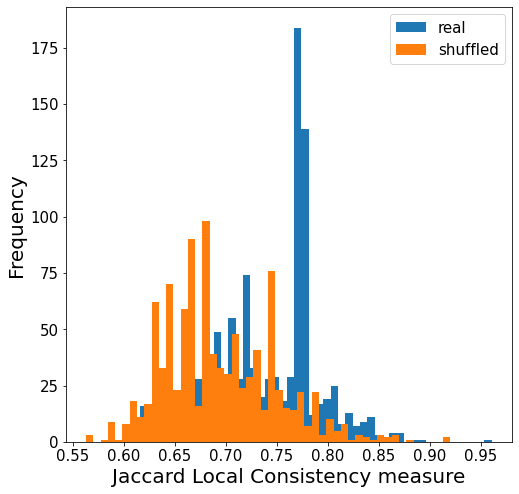

In [4]:
fig, ax = plt.subplots(1, figsize = (8,8))

for name in ['real','shuffled']:
    ax.hist(lincs_jaccard_consistency[name], bins = 50, label = name)
ax.legend(prop = {'size': 15})
ax.tick_params(labelsize = 15)
ax.set_ylabel("Frequency", size = 20)
ax.set_xlabel("Jaccard Local Consistency measure", size = 20)

## Doing better than Jaccard

Jaccard is in some ways a poor metric to assess 'closeness' of KOs in a given cell line. Essentially it's asking how big the overlap of DEGs is compared to the union set of all DEGs in both KOs. This penalises KOs which have large effects but which do overlap much more than would be expected by random chance. 

To get around this we can instead consider a contingency table associated with each pair of DEGs. Details of the exact procedure for what is meant by this can be found at: https://docs.google.com/presentation/d/16OQUTTwc4Vxeer_r4OdI-goRmM63LDO2/edit?usp=sharing&ouid=108619262275348296271&rtpof=true&sd=true 

Once we form a contingency table we can perform statistical association tests such as Fisher's exact test or $\chi^{2}$ contingency test. Running this for all genes at once takes a long time so for now i'll just run on a cut down set

In [8]:
from tools.metrics import vectorized_DEG_crosstab_distance

#For the full dataset this could take some time so i'll load up some cut down data
num_KOs = 100
lincs_cut, lincs_genes_cut, _ = get_lincs()
lincs_cut, lincs_genes_cut = lincs_cut[:num_KOs,:,:], lincs_genes_cut[:num_KOs]

THRESH = 1.96
lincs_cut[abs(lincs_cut) < THRESH] = 0
lincs_cut[lincs_cut > THRESH] = 1
lincs_cut[lincs_cut < -THRESH] = -1

lincs_cut_shuffled = np.copy(lincs_cut)
for cell_line in np.arange(lincs_cut.shape[-1]):
    order = np.arange(lincs_cut.shape[0])
    np.random.shuffle(order)
    lincs_cut_shuffled[:,:,cell_line] = lincs_cut[order,:,cell_line] 



Pulling folder parsed/literature_datasets/L1000


In [12]:
odds_ratios = {name: [] for name in ['real','shuffled']}
pvals = {name: [] for name in ['real','shuffled']}

for dset, name in zip((lincs_cut, lincs_cut_shuffled), ('real','shuffled')):
    for idx in np.arange(lincs_cut.shape[-1]):
        ors, ps = vectorized_DEG_crosstab_distance(
            dset[:,:,idx],                  #our DEG data for a single cell line 
            n = 2,                          #binarize the data instead of trinarising
            eps = 1e-6,                     #tolerance to add to contingency tables in the case that row or column marginals are zero for some row/column
            alt = 'greater'                 #alternative hypothesis to test - i.e. p-value reflects the chance of observing >= this many DEG overlaps compared with the null
            )
        odds_ratios[name].append(ors)
        pvals[name].append(ps)

odds_ratios = {name: np.stack(odds_ratios[name]) for name in odds_ratios}
pvals = {name: np.stack(pvals) for name in odds_ratios}

In [19]:
for name in odds_ratios:
    odds_ratios[name][np.isnan(odds_ratios[name])] = 1

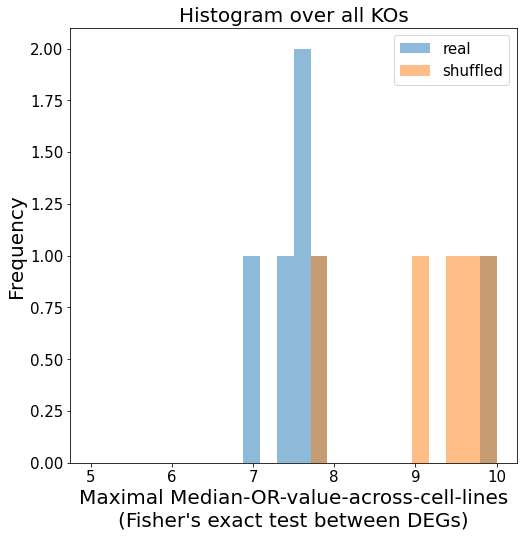

In [24]:
fig,ax = plt.subplots(1, figsize = (8,8))
indices = np.triu_indices(pvals['real'].shape[-1], 1)
for name in ['real','shuffled']:
    ax.hist(
        np.max(
            np.mean(odds_ratios[name],axis = 0),
            axis = 1),
        bins = np.linspace(5,10,25),
        alpha = 0.5,
        label = name
        )
ax.tick_params(labelsize = 15)
ax.set_xlabel("Maximal Median-OR-value-across-cell-lines\n(Fisher's exact test between DEGs)", size = 20)
ax.set_ylabel("Frequency", size = 20)
ax.set_title("Histogram over all KOs", size = 20)
ax.legend(prop = {'size':15})